In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 4.0 MB 32.1 MB/s 
     |████████████████████████████████| 1.2 MB 36.0 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 39.1 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 6.6 MB 32.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=625ccbc191145935049f1eadebbb5775cd540a3f119e8a8bcd93e5095e1b93a6
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!nvidia-smi

Tue Apr 19 13:45:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer, models

In [ ]:
from sklearn.decomposition import PCA
import torch
import random

In [ ]:
file_path = '/content/drive/MyDrive/Thesis/Bert_Fine_Tune/Update/bert_input.csv'

descriptions = pd.read_csv(file_path)
descriptions.head()

,id,label,price,house_description
0,14266,0,465000,Established farmlet that has had a major makeo...
1,14267,1,1220000,Rare opportunity to buy land of this size so c...
2,14268,0,560000,Excellent opportunity available for the home b...
3,14269,0,385000,* Comprising of 4 generous bedrooms with BIR's...
4,14270,0,500000,This part double storey home offers classic li...


In [ ]:
descriptions['house_description']

0        Established farmlet that has had a major makeo...
1        Rare opportunity to buy land of this size so c...
2        Excellent opportunity available for the home b...
3        * Comprising of 4 generous bedrooms with BIR's...
4        This part double storey home offers classic li...
                               ...                        
52846    Positioned perfectly on a large 621sqm (approx...
52847    * UNIT 1& 3 SOLD -  1 left.*Open plan kitchen,...
52848    Beautifully renovated and rendered home conven...
52849    Massive land dimensions offer an incredible op...
52850    This original flat roof Fibro shack home has u...
Name: house_description, Length: 52851, dtype: object

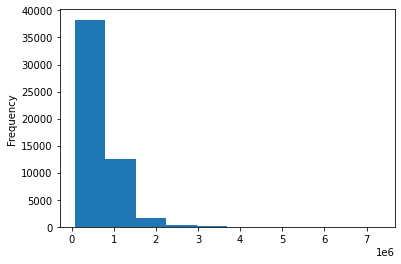

In [ ]:
descriptions["price"].plot(kind="hist")

In [ ]:
ex_len = []
for i in descriptions['house_description']:
  ex_len.append(len(i.split()))
print('max length of text: ', max(ex_len), 'words')

max length of text:  280 words


In [ ]:
#model = SentenceTransformer('all-distilroberta-v1')
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer('paraphrase-mpnet-base-v2')
new_dimension = 128

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

NameError: ignored

In [ ]:


print("Max Sequence Length:", model.max_seq_length)
model.max_seq_length = 280
print("Max Sequence Length:", model.max_seq_length)


Max Sequence Length: 500
Max Sequence Length: 280


In [ ]:
#To determine the PCA matrix, we need some example sentence embeddings.
#Here, we compute the embeddings for 20k random sentences from the AllNLI dataset
nli_sentences = descriptions['house_description']
#nli_sentences = list(nli_sentences)
#random.shuffle(nli_sentences)
#pca_train_sentences = nli_sentences[0:10000]
pca_train_sentences = nli_sentences
#pca_train_sentences
train_embeddings = model.encode(pca_train_sentences, show_progress_bar="true", convert_to_numpy=True)


Batches:   0%|          | 0/1652 [00:00<?, ?it/s]

In [ ]:

#Compute PCA on the train embeddings matrix
pca = PCA(n_components=new_dimension)
pca.fit(train_embeddings)
pca_comp = np.asarray(pca.components_)


In [ ]:
# We add a dense layer to the model, so that it will produce directly embeddings with the new size
dense = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=new_dimension, bias=False, activation_function=torch.nn.Identity())
dense.linear.weight = torch.nn.Parameter(torch.tensor(pca_comp))
model.add_module('dense', dense)

In [ ]:
#Our sentences we like to encode
sentences = descriptions['house_description']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences,show_progress_bar="true")

store_path='/content/drive/MyDrive/Thesis/Pretrained_embedding_bert/para_128_pca_all.pkl'
###########################################################################

# #Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding Length:", embedding.size)
#     print("Embedding:", embedding)
#     print("\n")

#Store sentences & embeddings on disc
with open(store_path, "wb") as fOut:
    pickle.dump({'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

#Load sentences & embeddings from disc
with open(store_path, "rb") as fIn:
    stored_data = pickle.load(fIn)
    embeddings_768 = stored_data['embeddings']

Batches:   0%|          | 0/1652 [00:00<?, ?it/s]

In [ ]:
embeddings_768.shape

(52851, 128)